# Project C
## Is there a pattern between cryptocurrencies?
### Jye Ying Chong
### 11/22/2017

Cryptocurrency is a digital or virtual currency, powered by blockchain technology and act as a medium of exchange using cryptography. It is hard to counterfeit due to its cryptographic security and not controlled by any central authority. This feature makes it immune to government interference or manipulation. Currently there is a lot of self-proclaimed experts on the trends and prediction of price movement. Even so, most of these analysis lacks a strong foundation of data and statistics to back up the claims. 

The purpose of this project is to determine whether there is any pattern on prices between different cryptocurrencies using correlation in python. We will collect data, analyze and visualize data on several cryptocurrencies. If there is a pattern we will then look further. We will use Bitcoin as a control variable and investigate other similar altcoins for correlation. 

Let's import the required dependencies.

In [2]:
import json
import requests
import pandas as pd
import os.path as oph
import os, errno
import pprint
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True) # this enables offline mode

The code below is used to deactivate auto-scrolling of the graphs.

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

After importing all the required dependencies, we created a class to retreive and store information for cryptocurrencies. We named the class CryptoCompare. Crptocompare API is used to extract data. 

In [4]:
class CryptoCompare(object):
    def __init__(self):
        self.crypto_list = []
        self.crypto_dict = {}
        self.is_save = False
        self.period = 'histoday'     
    
    def cryptocompare_histo(self, pair):    
        url = 'https://min-api.cryptocompare.com/data/{1}?fsym={0}&tsym=USD&limit=2000&aggregate=3&e=CCCAGG'.format(pair, self.period)
        # changing the limit number allows us to control the number of observation that we want to analyze.
        # Here we download data for 2000 observations which is the maximum limit.
        # This API allows us to extract data for every 3 time unit.
        resp = requests.get(url=url)
        data = json.loads(resp.text)
        cols = data['Data'][0].keys()
        btc_frame = pd.DataFrame(data['Data'], columns = cols)
        btc_frame['dtime'] = (pd.to_datetime(btc_frame['time'],unit='s'))
        return btc_frame
    
    def time_period(self, name):
        self.period = self.check_time_interval(name)
        return self
    
    def add(self, crypto_name):
        if type(crypto_name) == list:
            for i in crypto_name:
                self.crypto_list.append(i)
        else:
            self.crypto_list.append(crypto_name)
        return self
    
    def check_time_interval(self, value):
        return {
            'day': 'histoday',
            'hour': 'histohour',
            'minute': 'histominute'
        }[value]
    
    def isSave(self):
        self.is_save = True
        return self
    
    def done(self):
        directory = "FinalFantasy"
        # Create a loop to get multiple cryptocurrencies in USD Value
        if self.is_save == True:
            print("Saving dataframe to CSV")
            
            try:
                os.makedirs(directory)
            except OSError as e:
                print(e.errno)
                if e.errno != errno.EEXIST:
                    print("Folder exist")
                else:
                    print("Creating Directory " + directory)
        for crypto in self.crypto_list:
             #print(crypto)
            kryptonite = self.cryptocompare_histo(crypto)
            if self.is_save == True:
                starttime = kryptonite.iloc[0].time
                endtime = kryptonite.iloc[-1].time
                period = self.period
                name = crypto
                
                # Folder/starttime-endtime-period-cryptoname - CREATING FOLDER AND LABELING
                file_name = "{}/{}-{}-{}-{}".format(directory, starttime, endtime, period, name)
                if os.path.isfile(file_name) == False:
                    kryptonite.to_csv(file_name, sep='\t')
                else:
                    print("File already exist")
            self.crypto_dict[crypto] = kryptonite
        return self

Next, we create a nickname for the CryptoCompare classs called 'cc'. We then set up the parameters for the time period to save the data in a folder.

In [12]:
cc = CryptoCompare()
cc.time_period('hour')
cc.isSave()
cc.add(['BTC', 'ETH', 'BCH', 'XRP', 'LTC', 'DASH', 'NEO', 'XMR', 'XEM', 'ETC', 'LSK', 'QTUM', 'HSR', 'EOS', 'OMG', 'ZEC', 'XLM', 'WAVES', 'BTS'])
cc.done()

Saving dataframe to CSV


Here we normalized the percentage change in price of the cryptocurrency. The relative pricing for each cryptocurrency will be current price divided by the max price during period. The result is the relative value between 0 and 1. 

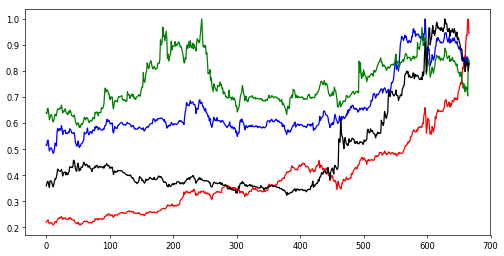

In [13]:
# Normalized change in cryptocurrency pricing.
normalized_btc = (cc.crypto_dict['BTC'].close / np.max(cc.crypto_dict['BTC'].close)) # Normalized Bitcoin prices.
normalized_eth = (cc.crypto_dict['ETH'].close / np.max(cc.crypto_dict['ETH'].close)) # Normalized Ethereum prices.
normalized_xrp = (cc.crypto_dict['XRP'].close / np.max(cc.crypto_dict['XRP'].close)) # Normalized Ripple prices.
normalized_dash = (cc.crypto_dict['DASH'].close / np.max(cc.crypto_dict['DASH'].close)) # Normalized Dash prices.
plt.figure(figsize=(10, 5), dpi=60)
plt.plot(normalized_btc, 'r', normalized_eth, 'b', normalized_xrp, 'g', normalized_dash, 'black')

From the graph above, we can see that Ethereum(blue) and Riple(green) has a similar pattern as they move closely together. Dash(black) and Bitcoin(red) however shows opppsite relationships. Next we want to further investigate the correlation between several cryptocurrencies.

For better visualization, we created functions for an interactive graph that shows the price of the cryptocurrency at any given point of time. 

In [5]:
def merge_dfs_on_column(dataframes, labels):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][labels[index]]
    return pd.DataFrame(series_dict)

def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale))
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

Next, we create a dataframe of all the cryptocurrency that we selected. namely, Bitcoin(BTC), Ethereum(ETH), Bitcoin Cash (BCH), Ripple(XRP), Litecoin(LTC), Dash(DASH), NEO(NEO), Monero(XMR), NEM(XEM), Ethereum Classic(ETC), Lisk(LSK), Qtum(QTUM), Hshare(HSR), EOS(EOS), OmiseGo(OMG), Zcash(ZEC), Stellar Lumens(XLM), Waves(WAVES) and Bitshares(BTS). These cryptocurrencies are selected with market capitalization of more than 1 billion US Dollars. We also added an index that show the date and time of the prices.

In [15]:
herpderp = ['BTC', 'ETH', 'BCH', 'XRP', 'LTC', 'DASH', 'NEO', 'XMR', 'XEM', 'ETC', 'LSK', 'QTUM', 'HSR', 'EOS', 'OMG', 'ZEC', 'XLM', 'WAVES', 'BTS']
something = []
for a in herpderp:
    new_data_frame = pd.DataFrame(list(cc.crypto_dict[a].close), columns=[a])
    something.append(new_data_frame)
df1 = merge_dfs_on_column(something, herpderp)
df2 = cc.crypto_dict['BTC'].dtime # Since BTC is the oldest cryptocoin, we use BTc time column to create the time index.
df1.index = df2

Call the dataframe to ensure correct structure.

In [16]:
df1.head()

,BCH,BTC,BTS,DASH,EOS,ETC,ETH,HSR,LSK,LTC,NEO,OMG,QTUM,WAVES,XEM,XLM,XMR,XRP,ZEC
dtime,,,,,,,,,,,,,,,,,,,
2017-09-15 21:00:00,428.88,3713.76,0.08950,285.56,0.6511,11.40,259.57,10.73,6.18,52.00,18.72,9.99,8.90,3.79,0.2210,0.01229,100.01,0.1846,187.02
2017-09-16 00:00:00,435.75,3741.29,0.08811,293.04,0.6688,11.70,259.33,10.81,6.20,53.07,19.25,10.32,8.90,3.89,0.2320,0.01221,100.59,0.1839,186.00
2017-09-16 03:00:00,459.86,3846.47,0.08801,299.29,0.6690,11.93,268.95,11.12,6.17,55.41,21.77,10.15,9.56,3.85,0.2320,0.01222,103.35,0.1897,188.87
2017-09-16 06:00:00,462.19,3866.75,0.08735,298.03,0.6629,11.87,269.38,11.17,6.19,55.93,22.32,10.59,9.36,3.95,0.2310,0.01219,102.92,0.1895,186.84
2017-09-16 09:00:00,439.57,3703.31,0.07955,287.98,0.6300,11.24,257.49,10.70,5.79,53.18,20.11,10.01,8.50,3.95,0.2085,0.01139,97.35,0.1829,175.97


The graph below is plot using 2000 observations between September to November 2017.

In [17]:
df_scatter(df1, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

Next, we want to find how the various currencies are correlated over a certain period of time using a heatmap.

In [6]:
def correlation_heatmap(df, title, colorscale, absolute_bounds=True):
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorscale=colorscale,  
        reversescale=True,
        colorbar=dict(title='Pearson Coefficient'),)
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

### Correlation heatmap

#### Positive Correlation 
Blue represents positive correlation, meaning the price increase of one cryptocurrency, the other will follow suit as well. 
The closer it is to dark blue color, the more positive the correlation that cryptocurrency is associated with the respected cryptocurrency.

#### Negative Correlation
Red represents negative correlation, which a price increase of one cryptocurrency will cause a price drop of the respected correlated cryptocurrency.
The closer it is to dark red color, the more negative impact that cryptocurrency will have on the respected correlated coin.

First we want to examine the correlation of the cryptocurrencies in one day in minutes. The time period parameter needs to be adjusted to minutes.

In [19]:
cc1 = CryptoCompare()
cc1.time_period('minute')
cc1.isSave()
cc1.add(['BTC', 'ETH', 'BCH', 'XRP', 'LTC', 'DASH', 'NEO', 'XMR', 'XEM', 'ETC', 'LSK', 'QTUM', 'HSR', 'EOS', 'OMG', 'ZEC', 'XLM', 'WAVES', 'BTS'])
cc1.done()

Saving dataframe to CSV
17
Creating Directory FinalFantasy


After setting up the data source we then proceed in creating the correlation matrix and the heatmap.

In [20]:
herpderp = ['BTC', 'ETH', 'BCH', 'XRP', 'LTC', 'DASH', 'NEO', 'XMR', 'XEM', 'ETC', 'LSK', 'QTUM', 'HSR', 'EOS', 'OMG', 'ZEC', 'XLM', 'WAVES', 'BTS']
something = []
for a in herpderp:
    new_data_frame = pd.DataFrame(list(cc1.crypto_dict[a].close), columns=[a])
    something.append(new_data_frame)
dm1 = merge_dfs_on_column(something, herpderp)
dm2 = cc1.crypto_dict['BTC'].dtime # Since BTC is the oldest cryptocoin, we use BTc time column to create the time index.
dm1.index = dm2

secm = dm1.loc['2017-12-07']
secm1 = secm.pct_change()
Correlation0 = secm1.corr(method='pearson') # standard correlation coefficient
print(correlation_heatmap(secm1, title="Daily Minutes Cryptocurrency Correlations", colorscale='Jet'))
Correlation0

None


,BCH,BTC,BTS,DASH,EOS,ETC,ETH,HSR,LSK,LTC,NEO,OMG,QTUM,WAVES,XEM,XLM,XMR,XRP,ZEC
BCH,1.000000,0.163942,0.028758,0.310737,0.097516,0.118897,0.149688,0.053310,0.046257,0.121959,0.156274,0.277590,0.080399,0.017941,0.174350,0.121358,0.262148,0.200720,0.205731
BTC,0.163942,1.000000,0.320089,0.240521,0.074868,0.128961,0.317830,0.309545,0.028258,0.373226,0.114792,0.154367,0.112291,-0.009001,0.254907,0.049500,0.283718,0.160756,0.256191
BTS,0.028758,0.320089,1.000000,0.053203,0.022065,0.051138,0.204056,0.216377,0.016754,0.186894,0.124743,0.111196,0.039416,0.023382,0.043262,0.132453,0.124339,0.158426,0.124859
DASH,0.310737,0.240521,0.053203,1.000000,0.132062,0.200750,0.173172,0.077505,0.002512,0.137756,0.191168,0.183287,0.026634,0.059687,0.148268,0.119473,0.386373,0.277992,0.309793
EOS,0.097516,0.074868,0.022065,0.132062,1.000000,0.108685,0.145696,-0.025912,0.128260,0.035721,0.044007,0.145155,0.065024,0.015593,0.112937,0.060632,0.144538,0.149523,0.174259
ETC,0.118897,0.128961,0.051138,0.200750,0.108685,1.000000,0.177975,0.063682,-0.012910,0.121800,0.041861,0.139398,0.015884,0.121134,0.074276,0.092853,0.148353,0.098103,0.056153
ETH,0.149688,0.317830,0.204056,0.173172,0.145696,0.177975,1.000000,0.207537,-0.009584,0.433531,0.186608,0.145730,0.303051,0.062361,0.050562,0.090914,0.259279,0.148684,0.118102
HSR,0.053310,0.309545,0.216377,0.077505,-0.025912,0.063682,0.207537,1.000000,-0.025760,0.188008,0.078208,0.144670,0.035972,-0.087144,-0.026105,-0.003118,0.059138,0.112551,0.109504
LSK,0.046257,0.028258,0.016754,0.002512,0.128260,-0.012910,-0.009584,-0.025760,1.000000,0.027338,0.008896,0.011943,-0.071868,-0.004301,-0.001513,0.000774,0.065192,0.039854,0.069267
LTC,0.121959,0.373226,0.186894,0.137756,0.035721,0.121800,0.433531,0.188008,0.027338,1.000000,0.119606,0.056292,0.052990,0.010975,0.127478,0.070200,0.192925,0.138402,0.133120


From the heatmap above, the cryptocurrencies shows weak correlation throughout the day. Maybe large minute to minute data is too detailed. What about hourly within a day? Next, we will examine the correlation of the cryptocurrencies in one day in hours.

In [21]:
# Daily correlation and heatmap in hours.
ein = df1.loc['2017-12-05']
ein1 = ein.pct_change()
correlation1 = ein1.corr(method='pearson') # standard correlation coefficient
print(correlation_heatmap(ein1, title="Daily Cryptocurrency Correlations", colorscale='Jet'))

None


As you can see, there is a lot of price movement throughout the day, with  most showing a strong positive correlation.

Then, we want to analyze the weekly correlation on the cryptocurrencies selected.

In [22]:
Weekly_df0 = df1.loc['2017-11-26':'2017-12-03']
Weekly_df1 = Weekly_df0.pct_change()
correlation2 = Weekly_df1.corr(method='pearson')
print(correlation_heatmap(Weekly_df1, title="Weekly Cryptocurrency Correlation", colorscale='Jet'))

None


From the weekly correlation heatmap, it shows positive correlation in overall across all cryptocurrencies, with more than half have positive correlation of more than 0.5. Next we want to review the correlation heatmap of the cryptocurrencies within a month.

In [23]:
Monthly_df0 = df1[df1.index.month == 11]
Monthly_df1 = Monthly_df0.pct_change()
correlation3 = Monthly_df1.corr(method='pearson')
print(correlation_heatmap(Monthly_df1, title="November Cryptocurrency Correlation", colorscale='Jet'))

None


Again, the monthly heatmap does not show any obvious correlation, similar to the Daily Minutes heatmap. Thus hourly data would be the best way in reviewing the relatioship between cryptocurrenmcy prices.

The heatmap provides good visualization of the correlation between cryptocurrencies but it is hard to find the highest or lowest correlation pairs from the heatmap. Now let's find the top five highest and lowest correlation.

In [7]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    shave = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            shave.add((cols[i], cols[j]))
    return shave

def get_top_pos_correlations(df, n=5):
    au_corr = df.corr().unstack()
    drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_top_neg_correlations(df, n=5):
    au_corr = df.corr().unstack()
    drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=drop).sort_values(ascending=True)
    return au_corr[0:n]

In [25]:
print("Top Weekly Positive Correlations")
print(get_top_pos_correlations(correlation2, 5))

print("Top Weekly Negative Correlations")
print(get_top_neg_correlations(correlation2, 5))

Top Weekly Positive Correlations
ETH  LTC     0.951112
BTC  ETH     0.924430
     LTC     0.913429
ETH  ZEC     0.910170
     QTUM    0.895462
dtype: float64
Top Weekly Negative Correlations
BCH   LSK   -0.401100
LSK   ZEC   -0.314401
DASH  LSK   -0.278421
HSR   LSK   -0.247849
LSK   XLM   -0.235630
dtype: float64


In [26]:
print("Top Monthly  Positive Correlations")
print(get_top_pos_correlations(correlation3, 5))

print("Top Monthly Negative Correlations")
print(get_top_neg_correlations(correlation3, 5))

Top Monthly  Positive Correlations
ETH  LTC    0.844051
XMR  ZEC    0.782417
ETH  XMR    0.779848
LTC  XMR    0.755027
ETH  ZEC    0.745349
dtype: float64
Top Monthly Negative Correlations
BCH  XEM   -0.709276
     BTC   -0.657303
     OMG   -0.651709
     XLM   -0.573646
     NEO   -0.522480
dtype: float64


Base on the correlation matrices,heatmaps and top negatve/positive correlations, there are two pairs that stand out over various  time periods(minute, hour,weekly, monthly). Bitcoin Cash(BCH) and Bitcoin(BTC) pair showed consistent negative correlation where as Ethereum(ETH) and Litecoin(LTC) shows strong positve correlation throughout the month of November. 

**Now, we know that the correlation varies greatly over time for multiple cryptocurrencies but what about the relationship with a specific coin?** 

To investigate this we used these Bitcoin clones : Bitcoin Cash('BCH'), Dash('DASH'), Vertcoin('VTC'), Dogecoin('Doge'), ZenCash('ZEN'), Nexus('NXS') and Bitdeal('BDL') to determine if they are correlated with Bitcoin. They're called Bitcoin clones due to the technology behind in creating them have similar blockchain technology as Bitcoin. A correlation matrix with the Bitcoin clones paired with Bitcoin with a weekly time horizon is created using hourly data. After that, a line chart is plotted to show the trend over time.

In [8]:
cc3 = CryptoCompare()
cc3.time_period('hour')
cc3.isSave()
cc3.add(['BTC', 'BCH', 'DASH', 'VTC', 'DOGE', 'ZEN', 'NXS', 'BDL'])
cc3.done()

Saving dataframe to CSV
17
Creating Directory FinalFantasy
File already exist
File already exist
File already exist
File already exist
File already exist
File already exist
File already exist


In [9]:
coins = ['BTC', 'BCH', 'DASH', 'VTC', 'DOGE', 'ZEN', 'NXS', 'BDL']
price = []
for a in coins:
    new_data_frame = pd.DataFrame(list(cc3.crypto_dict[a].close), columns=[a])
    price.append(new_data_frame)
dt1 = merge_dfs_on_column(price, coins)
dt2 = cc3.crypto_dict['BTC'].dtime
dt1.index = dt2

In [10]:
dt1.head()

,BCH,BDL,BTC,DASH,DOGE,NXS,VTC,ZEN
dtime,,,,,,,,
2017-09-15 21:00:00,428.88,0.1311,3713.76,285.56,0.000965,2.94,0.0,7.10
2017-09-16 00:00:00,435.75,0.1319,3741.29,293.04,0.000943,2.96,0.0,6.85
2017-09-16 03:00:00,459.86,0.1407,3846.47,299.29,0.000919,3.04,0.0,7.02
2017-09-16 06:00:00,462.19,0.1384,3866.75,298.03,0.000920,3.26,0.0,7.04
2017-09-16 09:00:00,439.57,0.1357,3703.31,287.98,0.000879,3.02,0.0,6.67


Next, we created weekly correlation matrices for the past 12 weeks.

In [54]:
initial_date = df1.index[0] # get initial date
old_end_date = None
array_of_ranges = []

for i in range(int(len(df1.index)/55)): # There's 56 periods in a week. Must start at 0-55 (56)
    if old_end_date is None:
        start_date = initial_date
    else:
        start_date = old_end_date
    
    end_date = start_date + datetime.timedelta(days=7)
    mask = (dt1.index > start_date) & (dt1.index <= end_date)
    array_of_ranges.append(dt1.loc[mask].fillna(0))
    old_end_date = end_date 

In [47]:
array_of_ranges[1].pct_change().corr(method='pearson')

,BCH,BDL,BTC,DASH,DOGE,NXS,VTC,ZEN
BCH,1.000000,0.345100,0.523601,0.501412,0.254430,0.103643,NaN,0.440653
BDL,0.345100,1.000000,0.322968,0.129312,0.451224,0.140005,NaN,0.310681
BTC,0.523601,0.322968,1.000000,0.728293,0.400860,0.342212,NaN,0.500836
DASH,0.501412,0.129312,0.728293,1.000000,0.244701,0.284489,NaN,0.417282
DOGE,0.254430,0.451224,0.400860,0.244701,1.000000,0.122935,NaN,0.314267
NXS,0.103643,0.140005,0.342212,0.284489,0.122935,1.000000,NaN,0.168223
VTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZEN,0.440653,0.310681,0.500836,0.417282,0.314267,0.168223,NaN,1.000000


In [48]:
b = range(len(array_of_ranges))
timecorr = []
for i in b:
    table = array_of_ranges[i].pct_change().corr(method='pearson')
    timecorr.append((i, table) )
    
btc_vals = []
for table in timecorr:
    table[1]['BTC']['Week'] = table[0] 
    btc_vals.append(table[1]['BTC'])

pairs = pd.DataFrame(btc_vals)
pairs.index = pairs['Week']
del pairs['Week']
pairs

,BCH,BDL,BTC,DASH,DOGE,NXS,VTC,ZEN
Week,,,,,,,,
0.0,0.803582,0.221018,1.0,0.720360,0.531929,0.583486,NaN,0.517104
1.0,0.523601,0.322968,1.0,0.728293,0.400860,0.342212,NaN,0.500836
2.0,0.424407,-0.025741,1.0,0.331261,0.370895,0.320220,NaN,0.620825
3.0,0.004527,0.075145,1.0,0.254887,0.407417,-0.081451,NaN,0.097055
4.0,0.369404,0.494502,1.0,0.625812,0.673792,0.516538,NaN,0.078053
5.0,0.291677,0.408389,1.0,0.285553,0.444995,0.107426,NaN,0.006408
6.0,0.287179,0.080782,1.0,-0.168027,0.205443,0.281721,0.049481,-0.214829
7.0,-0.155055,0.288622,1.0,0.307247,0.405145,0.257693,-0.091092,0.417145
8.0,-0.726711,0.301855,1.0,-0.270371,0.771934,0.539261,0.230539,0.638618


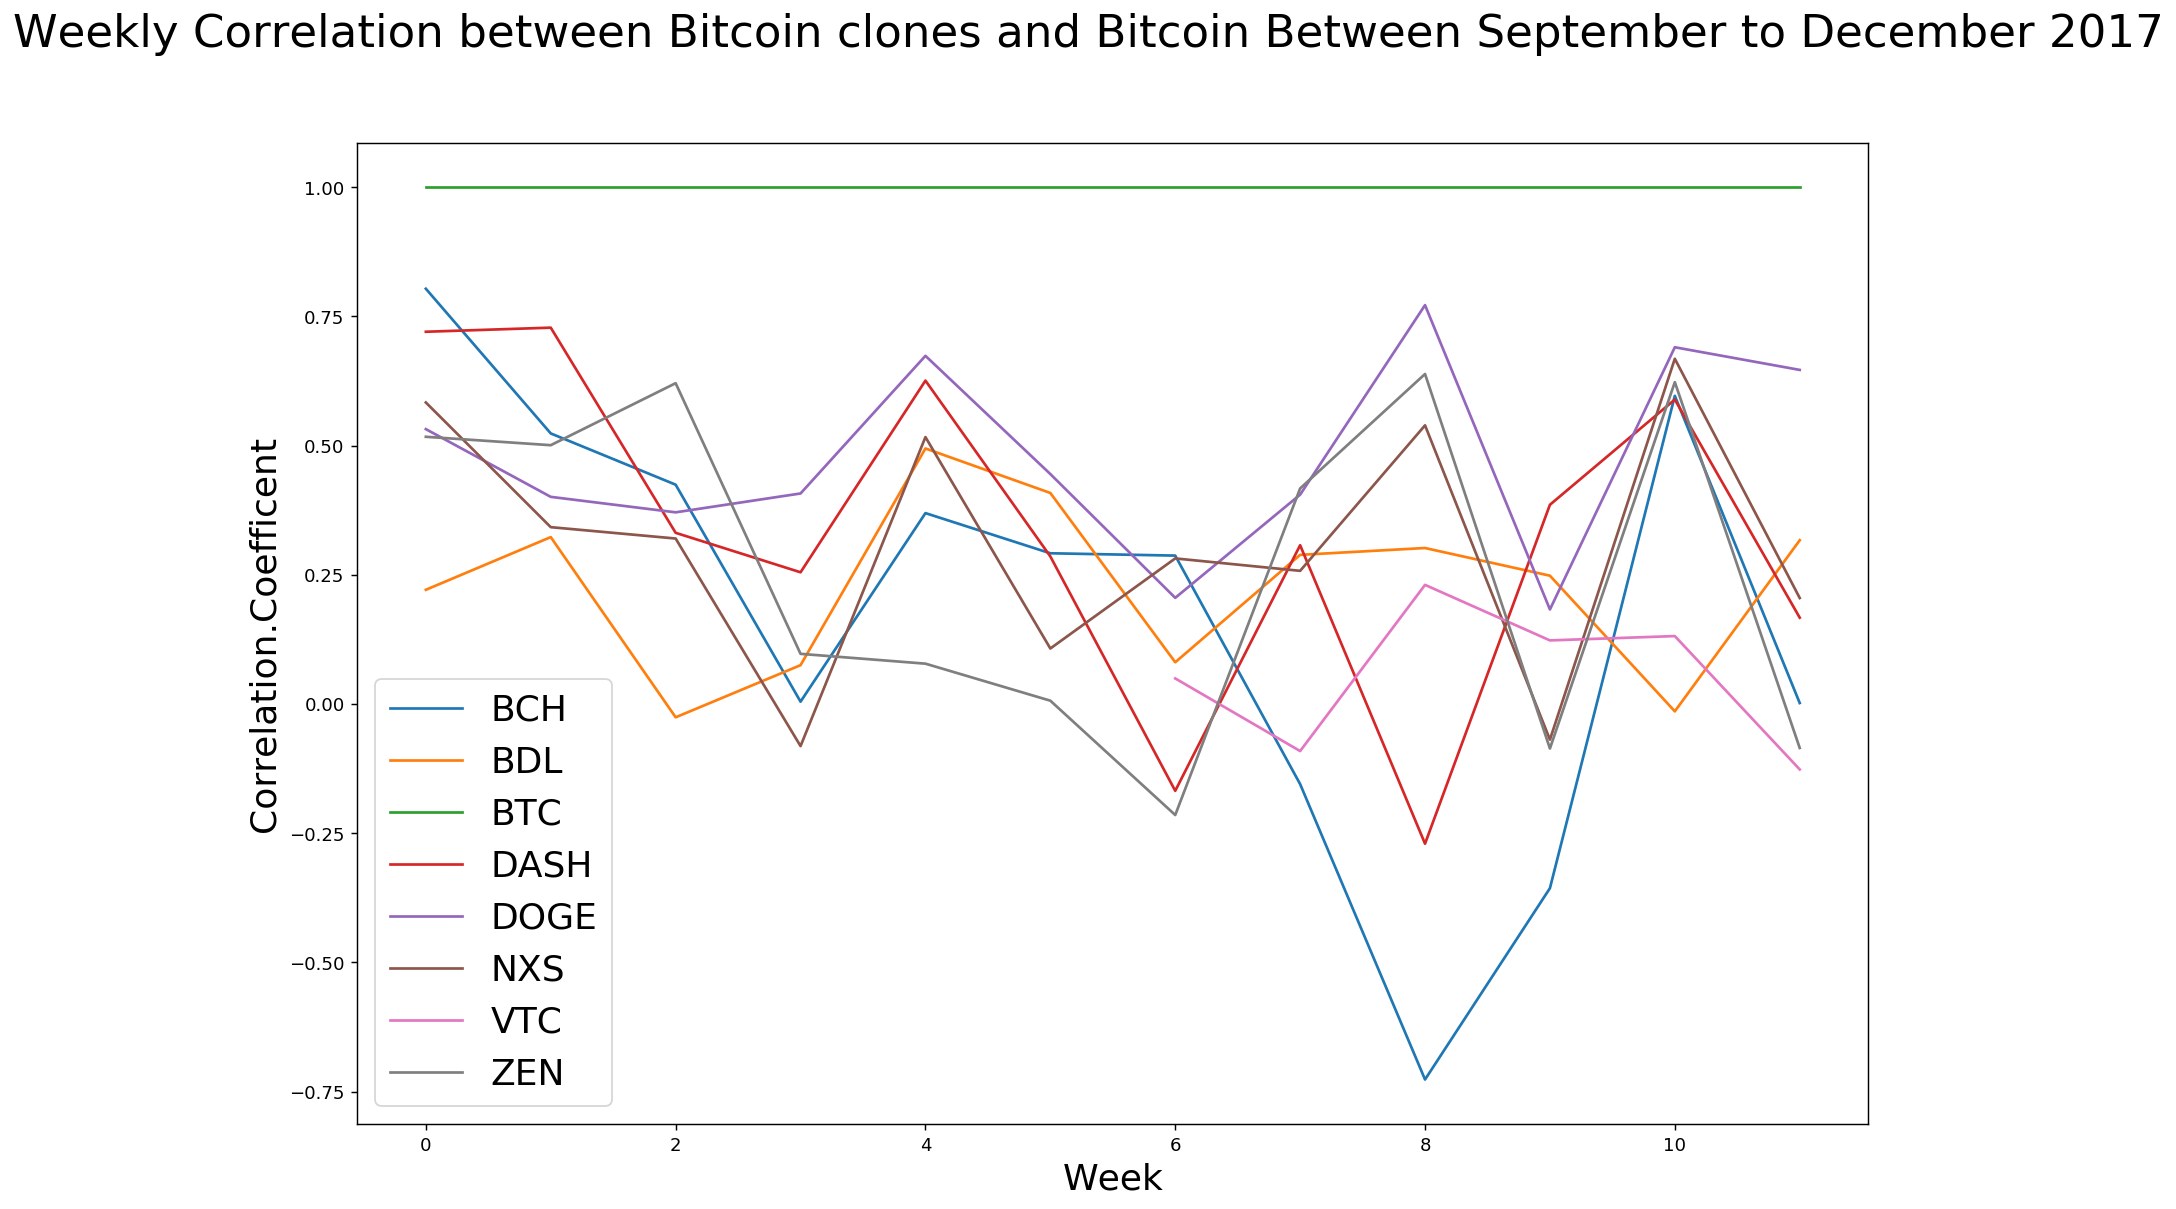

In [49]:
plt.figure(figsize=(15, 10), dpi=130)
plt.plot(pairs)
plt.suptitle('Weekly Correlation between Bitcoin clones and Bitcoin Between September to December 2017', fontsize=25)
plt.xlabel('Week', fontsize=20)
plt.ylabel('Correlation.Coefficent', fontsize=20)
plt.legend(pairs, fontsize=20)

According to the line chart above, we can conclude that several of the Bitcoin clones do show a fairly consistent correlation with Bitcoin itself. There are a few that shows opposite correlation and have yet to investigate further what caused the inverse relationship. For one, there is a sudden drop in the Bitcoin price on November 21 which might caused the purchase of the Bitcoin Cash(skyblue line - Week 8). Since cryptocurrencies are geopolitical free, we don't know if the price change is only affected purely by the trading of cryptocurrency on the exchange.

# What Next?
With just correlation it has shown so much regarding the price movement of the cryptocurrencies. Below is a few ideas to continue searching for stories within the data.

- Search for trends in trading volume data. The buy/sell volume ratios are likely relevant than the raw price data in predicting future price fluctuations.
- Create a predictive machine learning model on the data to predict tomorrow's prices. Does the Efficient Market Hypothesis stands true for this approach?
- Quantify tweets and news from social media through textual analysis and text mining. Does the hype from social media pushes the Bitcoin price to a higher level?
- Create a trading bot using the analysis and some trading rules such as trend-following and countertrend indicators to find a good and balanced portfolio
